In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pltimport 
import os, copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import time
import math, tqdm
import seaborn as sns
from lib.model import MLP, RNN_LSTM, RNN_ILSTM, RNN_SLSTM
from lib.data import Data, MNIST_add_data
from lib.utils import timeSince
from lib.train import TrainMLP, TrainRNN
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from lib.evaluation import Evaluation, plot_confusion

In [3]:
root = './mnist_data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

### MLP: sanity check

In [3]:
net = MLP([784, 300, 10])
optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = Data(train_set)

trainer = TrainMLP(net, optimizer, criterion, train_data)
trainer.train()

31 0% (0m 7s) 0.0564 
62 1% (0m 8s) 0.0293 
93 2% (0m 8s) 0.0197 
124 3% (0m 8s) 0.0177 
155 4% (0m 9s) 0.0147 
186 5% (0m 9s) 0.0141 
217 6% (0m 9s) 0.0137 
248 7% (0m 10s) 0.0132 
279 8% (0m 10s) 0.0150 
310 9% (0m 11s) 0.0133 
341 10% (0m 11s) 0.0128 
372 11% (0m 11s) 0.0131 
403 12% (0m 12s) 0.0122 
434 13% (0m 12s) 0.0125 
465 14% (0m 12s) 0.0115 
496 15% (0m 12s) 0.0099 
527 16% (0m 13s) 0.0116 
558 17% (0m 13s) 0.0101 
589 18% (0m 13s) 0.0097 
620 19% (0m 14s) 0.0112 
651 20% (0m 14s) 0.0081 
682 21% (0m 14s) 0.0078 
713 22% (0m 15s) 0.0085 
744 23% (0m 15s) 0.0096 
775 24% (0m 16s) 0.0090 
806 25% (0m 16s) 0.0100 
837 26% (0m 16s) 0.0085 
868 27% (0m 16s) 0.0090 
899 28% (0m 17s) 0.0091 
930 29% (0m 17s) 0.0086 
961 30% (0m 17s) 0.0088 
992 31% (0m 18s) 0.0075 
1023 32% (0m 18s) 0.0074 
1054 33% (0m 18s) 0.0082 
1085 34% (0m 19s) 0.0081 
1116 35% (0m 19s) 0.0074 
1147 36% (0m 19s) 0.0072 
1178 37% (0m 20s) 0.0078 
1209 38% (0m 20s) 0.0059 
1240 39% (0m 20s) 0.0075 
1271 40% (0m

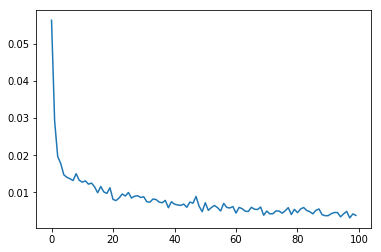

In [4]:
plt.plot(trainer.all_losses)
plt.show()

accuracy is 96.01%


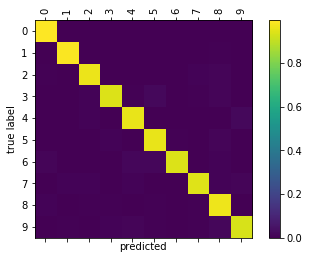

In [5]:
n_categories = 10
evaluation = Evaluation(net, Data(test_set))
confusion = evaluation.confusion(n_categories, n_confusion=10000)
plot_confusion(confusion)

# Sequence task: 1-3 mnist digits addition mod 10 (one output for seq)

In [4]:
# sample n_samples correctly classified examples
def getCorrect(net, data, n_samples=100):
    xs = []
    ys = []

    i = 0
    while i < n_samples:
        d = data.random_batch(batch_size=1)
        x, y = d[0], d[1]
        output = net.eval_forward(*d)
        _, ans = torch.max(output, 1)
        if ans.item() != y.item(): # incorrect
            continue

        xs.append(x)
        ys.append(y)
        i += 1
    return xs, ys

def show_examples(net, xs, ys, n_show=3):
    for x, y in zip(xs[:n_show], ys[:n_show]):
        yhat = net.eval_forward(x, y, [len(x)])
        val, ind = torch.max(yhat, 1)
        
        n_images, _, w_h = x.shape
        print('label: %d, predict: %d, prob: %.2f' % (y.item(), ind.item(), np.exp(val.item())))
        for i in range(n_images):
            plt.subplot(1,3,i+1)
            plt.imshow(x[i].view(28,28).detach().numpy())
        plt.show()

### 2 layer MLP on the last step

In [32]:
from lib.model import RNN_MLP

n_hidden = 300
n_categories = 10
net = RNN_MLP(784, n_hidden, n_categories)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set, min_length=1, max_length=3)

trainer = TrainRNN(net, optimizer, criterion, train_data)
trainer.train()

31 0% (0m 1s) 0.0716 
62 1% (0m 2s) 0.0694 
93 2% (0m 3s) 0.0695 
124 3% (0m 4s) 0.0690 
155 4% (0m 6s) 0.0678 
186 5% (0m 7s) 0.0672 
217 6% (0m 8s) 0.0670 
248 7% (0m 9s) 0.0679 
279 8% (0m 10s) 0.0660 
310 9% (0m 11s) 0.0665 
341 10% (0m 12s) 0.0672 
372 11% (0m 14s) 0.0660 
403 12% (0m 15s) 0.0661 
434 13% (0m 17s) 0.0670 
465 14% (0m 18s) 0.0661 
496 15% (0m 19s) 0.0669 
527 16% (0m 20s) 0.0661 
558 17% (0m 21s) 0.0666 
589 18% (0m 23s) 0.0650 
620 19% (0m 24s) 0.0663 
651 20% (0m 25s) 0.0670 
682 21% (0m 26s) 0.0665 
713 22% (0m 27s) 0.0658 
744 23% (0m 29s) 0.0654 
775 24% (0m 30s) 0.0663 
806 25% (0m 31s) 0.0668 
837 26% (0m 32s) 0.0648 
868 27% (0m 34s) 0.0660 
899 28% (0m 35s) 0.0657 
930 29% (0m 36s) 0.0658 
961 30% (0m 38s) 0.0661 
992 31% (0m 39s) 0.0669 
1023 32% (0m 40s) 0.0646 
1054 33% (0m 41s) 0.0666 
1085 34% (0m 42s) 0.0667 
1116 35% (0m 43s) 0.0656 
1147 36% (0m 45s) 0.0664 
1178 37% (0m 46s) 0.0648 
1209 38% (0m 47s) 0.0669 
1240 39% (0m 48s) 0.0658 
1271 40% (0m 

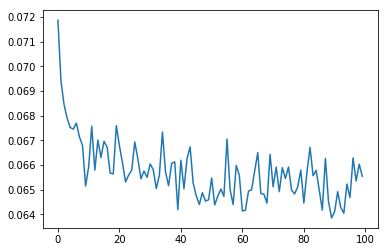

In [81]:
plt.plot(trainer.all_losses)
plt.show()

accuracy is 77.40%


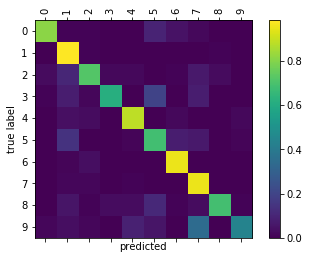

In [16]:
n_categories = 10
evaluation = Evaluation(net, MNIST_add_data(test_set, min_length=1, max_length=1))
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### IMLP

In [58]:
from lib.model import RNN_IMLP

n_hidden = 300
n_categories = 10
net = RNN_IMLP(784, n_hidden, n_categories)
net.set_max_length(3)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set, min_length=1, max_length=3)

trainer = TrainRNN(net, optimizer, criterion, train_data)
trainer.train()

31 0% (0m 1s) 0.0696 
62 1% (0m 2s) 0.0632 
93 2% (0m 4s) 0.0574 
124 3% (0m 5s) 0.0560 
155 4% (0m 6s) 0.0563 
186 5% (0m 7s) 0.0548 
217 6% (0m 9s) 0.0555 
248 7% (0m 10s) 0.0547 
279 8% (0m 11s) 0.0531 
310 9% (0m 13s) 0.0541 
341 10% (0m 14s) 0.0551 
372 11% (0m 15s) 0.0504 
403 12% (0m 17s) 0.0530 
434 13% (0m 18s) 0.0530 
465 14% (0m 20s) 0.0531 
496 15% (0m 21s) 0.0530 
527 16% (0m 22s) 0.0526 
558 17% (0m 23s) 0.0521 
589 18% (0m 25s) 0.0530 
620 19% (0m 26s) 0.0528 
651 20% (0m 27s) 0.0536 
682 21% (0m 28s) 0.0543 
713 22% (0m 30s) 0.0514 
744 23% (0m 31s) 0.0521 
775 24% (0m 32s) 0.0528 
806 25% (0m 33s) 0.0511 
837 26% (0m 35s) 0.0520 
868 27% (0m 36s) 0.0532 
899 28% (0m 37s) 0.0527 
930 29% (0m 39s) 0.0515 
961 30% (0m 40s) 0.0538 
992 31% (0m 41s) 0.0512 
1023 32% (0m 43s) 0.0516 
1054 33% (0m 44s) 0.0515 
1085 34% (0m 45s) 0.0537 
1116 35% (0m 47s) 0.0517 
1147 36% (0m 48s) 0.0509 
1178 37% (0m 49s) 0.0503 
1209 38% (0m 50s) 0.0515 
1240 39% (0m 52s) 0.0516 
1271 40% (0m

accuracy is 93.50%


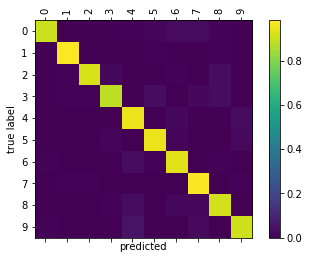

In [60]:
n_categories = 10
evaluation = Evaluation(net, MNIST_add_data(test_set, min_length=1, max_length=1))
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### SMLP

In [31]:
from lib.model import RNN_SMLP

n_hidden = 300
n_categories = 10
net = RNN_SMLP(784, n_hidden, n_categories)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set, min_length=1, max_length=3)

trainer = TrainRNN(net, optimizer, criterion, train_data)
trainer.train()

31 0% (0m 1s) 0.0722 
62 1% (0m 2s) 0.0697 
93 2% (0m 3s) 0.0681 
124 3% (0m 5s) 0.0681 
155 4% (0m 6s) 0.0672 
186 5% (0m 7s) 0.0683 
217 6% (0m 8s) 0.0670 
248 7% (0m 9s) 0.0684 
279 8% (0m 11s) 0.0669 
310 9% (0m 12s) 0.0670 
341 10% (0m 14s) 0.0673 
372 11% (0m 15s) 0.0662 
403 12% (0m 16s) 0.0658 
434 13% (0m 18s) 0.0675 
465 14% (0m 19s) 0.0667 
496 15% (0m 20s) 0.0658 
527 16% (0m 21s) 0.0662 
558 17% (0m 22s) 0.0668 
589 18% (0m 23s) 0.0645 
620 19% (0m 24s) 0.0668 
651 20% (0m 26s) 0.0657 
682 21% (0m 27s) 0.0658 
713 22% (0m 28s) 0.0667 
744 23% (0m 29s) 0.0658 
775 24% (0m 30s) 0.0665 
806 25% (0m 32s) 0.0661 
837 26% (0m 33s) 0.0663 
868 27% (0m 35s) 0.0667 
899 28% (0m 36s) 0.0658 
930 29% (0m 38s) 0.0674 
961 30% (0m 39s) 0.0653 
992 31% (0m 40s) 0.0660 
1023 32% (0m 41s) 0.0641 
1054 33% (0m 43s) 0.0665 
1085 34% (0m 44s) 0.0652 
1116 35% (0m 45s) 0.0662 
1147 36% (0m 46s) 0.0666 
1178 37% (0m 48s) 0.0651 
1209 38% (0m 49s) 0.0637 
1240 39% (0m 51s) 0.0666 
1271 40% (0m 

accuracy is 92.00%


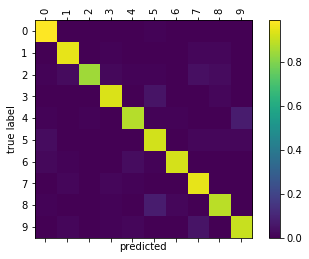

In [24]:
n_categories = 10
evaluation = Evaluation(net, MNIST_add_data(test_set, min_length=1, max_length=1))
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### Independent LSTM (each time step uses an independent LSTM cell)

In [ ]:
from lib.model import RNN_ILSTM

n_hidden = 300
n_categories = 10
net = RNN_ILSTM(784, n_hidden, n_categories)
net.set_max_length(3)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)

trainer = TrainRNN(net, optimizer, criterion, train_data)
trainer.train()

31 0% (0m 3s) 0.0709 
62 1% (0m 6s) 0.0635 
93 2% (0m 10s) 0.0577 
124 3% (0m 13s) 0.0556 
155 4% (0m 16s) 0.0537 
186 5% (0m 20s) 0.0534 
217 6% (0m 23s) 0.0529 
248 7% (0m 26s) 0.0521 
279 8% (0m 29s) 0.0513 
310 9% (0m 31s) 0.0506 
341 10% (0m 34s) 0.0498 
372 11% (0m 37s) 0.0499 
403 12% (0m 40s) 0.0502 
434 13% (0m 43s) 0.0481 
465 14% (0m 47s) 0.0517 
496 15% (0m 50s) 0.0499 
527 16% (0m 54s) 0.0486 
558 17% (0m 57s) 0.0474 
589 18% (1m 0s) 0.0489 
620 19% (1m 2s) 0.0463 
651 20% (1m 6s) 0.0477 
682 21% (1m 10s) 0.0463 
713 22% (1m 13s) 0.0461 
744 23% (1m 16s) 0.0459 
775 24% (1m 19s) 0.0469 
806 25% (1m 22s) 0.0481 
837 26% (1m 26s) 0.0464 
868 27% (1m 29s) 0.0464 
899 28% (1m 32s) 0.0459 
930 29% (1m 36s) 0.0454 
961 30% (1m 39s) 0.0428 
992 31% (1m 42s) 0.0430 
1023 32% (1m 46s) 0.0444 
1054 33% (1m 48s) 0.0429 
1085 34% (1m 51s) 0.0453 
1116 35% (1m 54s) 0.0436 
1147 36% (1m 58s) 0.0430 
1178 37% (2m 1s) 0.0442 
1209 38% (2m 5s) 0.0423 
1240 39% (2m 8s) 0.0414 
1271 40% (2m 

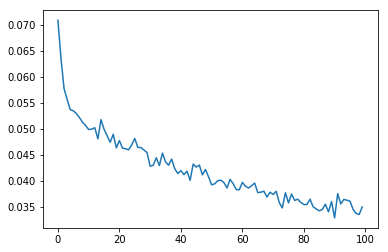

In [37]:
plt.plot(trainer.all_losses)
plt.show()

accuracy is 93.40%


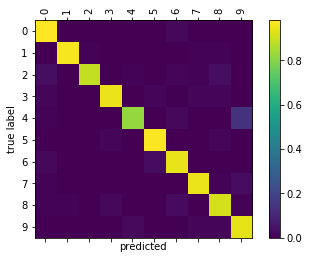

In [38]:
n_categories = 10
evaluation = Evaluation(net, MNIST_add_data(test_set, min_length=1, max_length=1))
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### Staged LSTM

In [55]:
from lib.model import RNN_SLSTM
n_hidden = 300
n_categories = 10
net = RNN_SLSTM(784, n_hidden, n_categories)
net.set_shared_groups([[0, 1], [2]])

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)

trainer = TrainRNN(net, optimizer, criterion, train_data)
trainer.train()

31 0% (0m 3s) 0.0715 
62 1% (0m 6s) 0.0667 
93 2% (0m 11s) 0.0643 
124 3% (0m 14s) 0.0597 
155 4% (0m 16s) 0.0577 
186 5% (0m 19s) 0.0536 
217 6% (0m 22s) 0.0538 
248 7% (0m 26s) 0.0541 
279 8% (0m 30s) 0.0527 
310 9% (0m 33s) 0.0490 
341 10% (0m 36s) 0.0506 
372 11% (0m 38s) 0.0501 
403 12% (0m 42s) 0.0502 
434 13% (0m 46s) 0.0469 
465 14% (0m 49s) 0.0480 
496 15% (0m 52s) 0.0469 
527 16% (0m 55s) 0.0463 
558 17% (0m 59s) 0.0459 
589 18% (1m 2s) 0.0454 
620 19% (1m 5s) 0.0450 
651 20% (1m 9s) 0.0421 
682 21% (1m 12s) 0.0449 
713 22% (1m 16s) 0.0455 
744 23% (1m 19s) 0.0437 
775 24% (1m 24s) 0.0427 
806 25% (1m 28s) 0.0424 
837 26% (1m 32s) 0.0413 
868 27% (1m 34s) 0.0430 
899 28% (1m 38s) 0.0422 
930 29% (1m 42s) 0.0422 
961 30% (1m 46s) 0.0423 
992 31% (1m 49s) 0.0421 
1023 32% (1m 53s) 0.0415 
1054 33% (1m 55s) 0.0401 
1085 34% (1m 59s) 0.0410 
1116 35% (2m 2s) 0.0415 
1147 36% (2m 6s) 0.0389 
1178 37% (2m 10s) 0.0405 
1209 38% (2m 14s) 0.0391 
1240 39% (2m 17s) 0.0401 
1271 40% (2m

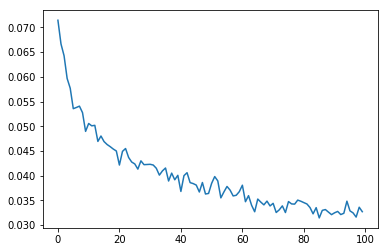

In [56]:
plt.plot(trainer.all_losses)
plt.show()

accuracy is 93.50%


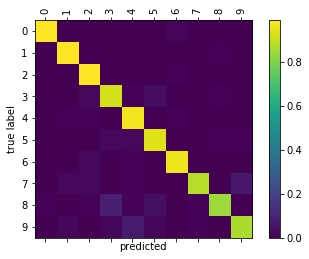

In [57]:
n_categories = 10
evaluation = Evaluation(net, MNIST_add_data(test_set, min_length=1, max_length=1))
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### LSTM

In [7]:
n_hidden = 300
n_categories = 10
net = RNN_LSTM(784, n_hidden, n_categories)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)

trainer = TrainRNN(net, optimizer, criterion, train_data)
trainer.train()

31 0% (0m 1s) 0.0716 
62 1% (0m 2s) 0.0696 
93 2% (0m 4s) 0.0669 
124 3% (0m 6s) 0.0621 
155 4% (0m 8s) 0.0581 
186 5% (0m 11s) 0.0555 
217 6% (0m 15s) 0.0527 
248 7% (0m 19s) 0.0519 
279 8% (0m 21s) 0.0503 
310 9% (0m 24s) 0.0500 
341 10% (0m 27s) 0.0508 
372 11% (0m 31s) 0.0490 
403 12% (0m 34s) 0.0482 
434 13% (0m 39s) 0.0459 
465 14% (0m 43s) 0.0474 
496 15% (0m 47s) 0.0468 
527 16% (0m 50s) 0.0454 
558 17% (0m 53s) 0.0464 
589 18% (0m 58s) 0.0445 
620 19% (1m 2s) 0.0446 
651 20% (1m 6s) 0.0431 
682 21% (1m 10s) 0.0433 
713 22% (1m 14s) 0.0443 
744 23% (1m 18s) 0.0430 
775 24% (1m 20s) 0.0431 
806 25% (1m 25s) 0.0417 
837 26% (1m 29s) 0.0394 
868 27% (1m 33s) 0.0410 
899 28% (1m 36s) 0.0410 
930 29% (1m 38s) 0.0407 
961 30% (1m 42s) 0.0381 
992 31% (1m 47s) 0.0399 
1023 32% (1m 50s) 0.0384 
1054 33% (1m 53s) 0.0384 
1085 34% (1m 57s) 0.0392 
1116 35% (1m 58s) 0.0356 
1147 36% (2m 2s) 0.0346 
1178 37% (2m 5s) 0.0397 
1209 38% (2m 11s) 0.0344 
1240 39% (2m 17s) 0.0342 
1271 40% (2m 2

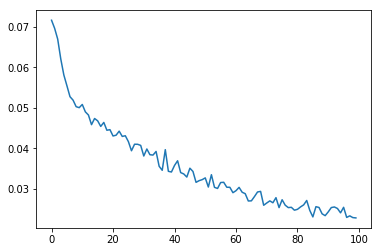

In [8]:
plt.plot(trainer.all_losses)
plt.show()

accuracy is 93.70%


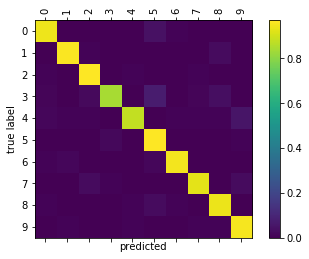

In [14]:
n_categories = 10
evaluation = Evaluation(net, MNIST_add_data(test_set, min_length=1, max_length=1))
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

label: 9, predict: 9, prob: 0.70


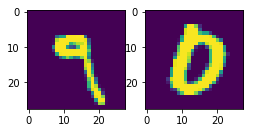

label: 6, predict: 6, prob: 0.44


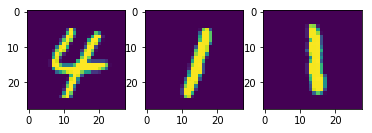

label: 8, predict: 8, prob: 0.23


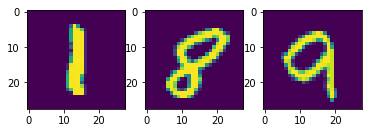

In [27]:
xs, ys = getCorrect(net, MNIST_add_data(test_set, min_length=2, max_length=3))    
show_examples(net, xs, ys)

### proposed methods: Mixture of Weights

$$W_t = \sum_{k=1}^K \lambda^{(k)}_t W^{(k)}$$ 


In [ ]:
from lib.model import RNN_MoW
from lib.train import TrainMetaRNN

n_hidden = 300
n_categories = 10
net = RNN_MoW(784, n_hidden, n_categories)
net.setKT(2,3)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)

trainer = TrainMetaRNN(net, optimizer, criterion, train_data)
trainer.train()

accuracy is 92.00%


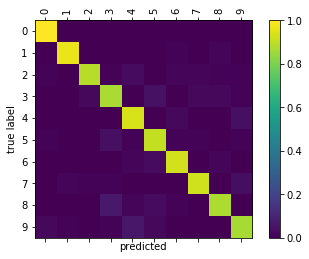

In [135]:
n_categories = 10
evaluation = Evaluation(net, MNIST_add_data(test_set, min_length=1, max_length=1))
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)